# FISTA

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import re

In [2]:
DATA_PATH = '../../../OneDrive - m.titech.ac.jp/Lab/data'

In [3]:
def images_to_matrix(folder_path, convert_gray=False, is_binary=False, seed=0, ratio=1.0, use_all=False):
    files = os.listdir(folder_path)
    files.sort(key=lambda f: int(re.search('random_noise_(\d+).png', f).group(1)))

    if seed != 0:
        random.seed(seed)
        random.shuffle(files)

    total_files = len(files)
    number_of_files_to_load = int(total_files * ratio)

    if use_all:
        selected_files = files[:number_of_files_to_load]
        selected_files.sort(key=lambda f: int(re.search('random_noise_(\d+).png', f).group(1)))
    else:
        # 特定の一部
        selected_indices = []
        a = np.arange(0, 4096).reshape(64, 64)
        a = np.triu(a)
        a = a.flatten().tolist()
        selected_indices = [i for i in a if i != 0]
        selected_indices.insert(0, 0)
        for i in range(0, 64):
            range_i = list(range(63 + 63 * i, 64 * (i + 1)))
            selected_indices += range_i
        selected_files = [files[i] for i in selected_indices if i < total_files]

    images = []
    use_list = []

    for file in selected_files:
        index = int(re.sub(r'\D', '', file))
        use_list.append(index)
        img = Image.open(os.path.join(folder_path, file))
        if convert_gray:
            img = img.convert('L')
        if is_binary:
            img = img.point(lambda x: 255 if x else 0, 'L')
        img_array = np.asarray(img).flatten()
        img_array = img_array / 255
        images.append(img_array)

    # diff = list(set(range(1, len(files)+1))-set(use_list))
    # print("Didn't use:", sorted(diff))
    print("Used:", use_list)

    return np.column_stack(images)


def update_H(H, G, F, lmd, threshold):
    i = 1
    t = 1
    L = max_eigenvalue(F.T @ F) * 3
    print('L: {}'.format(L))
    H_1_prev = H.copy()
    H_2_prev = H.copy()
    while True:
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        grad = 2 * (H_2_prev @ F - G) @ F.T
        H_1 = soft_thresh(H_2_prev - (1 / L) * grad, lmd / L)
        H_2 = H_1 + (t - 1) / t_new * (H_1 - H_1_prev)
        error = np.linalg.norm(H_2 - H_2_prev, 'fro')

        print('iter: {}, error: {}'.format(i, error))
        if error < threshold:
            break
        t = t_new.copy()
        H_1_prev = H_1.copy()
        H_2_prev = H_2.copy()
        i += 1
    return H_2


def max_eigenvalue(A):
    eigenvalues, eigenvectors = np.linalg.eig(A)
    return np.max(eigenvalues)


def soft_thresh(x, lambda_val):
    return np.sign(x) * np.maximum(np.abs(x) - lambda_val, 0)

In [4]:
# パラメータ設定
n = 64
m = 128
lmd = 10
threshold = 0.001
seed = 2

In [5]:
# 真のシステム行列の計算
G_full = images_to_matrix(f"{DATA_PATH}/random_noise{n}_cap/", convert_gray=True, use_all=True)
print(G_full.shape)
# F_full = images_to_matrix(f"{DATA_PATH}/Hadamard{n}_input/", is_binary=True, use_all=True)
# print(F_full.shape)
# H1 = np.zeros((m**2, n**2))
# G1s = []
# for i in range(n**2):
#     G1s.append(G_full[:, 0])
# H1 = np.column_stack(G1s)
# F_hat_full = 2 * F_full - 1
# G_hat_full = 2 * G_full - H1
# H_true = G_hat_full @ F_hat_full.T / (n**2)

Used: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 2

In [6]:
# del F_full
# del F_hat_full
# del G_hat_full
# gc.collect()

In [7]:
# np.save('../data/systemMatrix/H_matrix_true.npy', H_true)
H_true = np.load(f"{DATA_PATH}/systemMatrix/H_matrix_true.npy")

In [8]:
# 初期化
H = np.zeros((m**2, n**2))

In [9]:
ratio = 0.5

In [10]:
G = images_to_matrix(f"{DATA_PATH}/random_noise{n}_cap/", convert_gray=True, seed=seed, ratio=ratio, use_all=True)
F = images_to_matrix(f"{DATA_PATH}/random_noise{n}_input/", convert_gray=True, seed=seed, ratio=ratio, use_all=True)
print(G.shape)
print(F.shape)

Used: [1, 2, 4, 5, 9, 10, 12, 14, 16, 17, 19, 23, 24, 25, 27, 32, 36, 38, 40, 41, 42, 45, 46, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 70, 77, 78, 81, 83, 85, 86, 89, 91, 92, 93, 94, 96, 106, 107, 108, 109, 114, 116, 117, 120, 123, 124, 128, 130, 132, 134, 136, 137, 141, 142, 143, 144, 145, 150, 151, 152, 153, 155, 156, 158, 159, 160, 162, 163, 164, 166, 167, 169, 170, 171, 173, 178, 181, 183, 184, 187, 189, 191, 197, 198, 200, 202, 203, 205, 206, 207, 209, 211, 212, 213, 214, 216, 219, 223, 225, 227, 228, 230, 231, 234, 235, 236, 237, 238, 239, 242, 243, 244, 247, 249, 250, 252, 255, 257, 262, 263, 264, 267, 268, 270, 271, 273, 275, 276, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 291, 293, 296, 300, 301, 304, 305, 306, 308, 310, 311, 313, 318, 320, 321, 322, 323, 324, 325, 326, 329, 332, 335, 336, 338, 339, 341, 343, 349, 350, 351, 356, 357, 358, 359, 361, 362, 363, 364, 365, 372, 373, 374, 375, 380, 382, 384, 386, 388, 389, 391, 392, 395, 396, 39

In [11]:
H1 = np.zeros((m**2, 1))
G1s = []
for _ in range(F.shape[1]):
    G1s.append(G_full[:, 0])
H1 = np.column_stack(G1s)
F_hat = 2 * F - 1
G_hat = 2 * G - H1
print(F_hat.shape)
print(G_hat.shape)

(4096, 2048)
(16384, 2048)


In [12]:
# Hを更新
H = update_H(H, G_hat, F_hat, lmd, threshold)

np.save(f"{DATA_PATH}/systemMatrix/H_matrix_FISTA_rand_{100*ratio}p.npy", H)

# plt.figure(figsize=(12, 8))
# sns.heatmap(H, annot=False, cmap='viridis')

L: 35749.303448245715
iter: 1, error: 3.580731118708038
iter: 2, error: 2.943839729359159
iter: 3, error: 2.359368042947347
iter: 4, error: 1.9466666178840146
iter: 5, error: 1.6870614612309092
iter: 6, error: 1.5245213221887153
iter: 7, error: 1.4132273773493838
iter: 8, error: 1.3253386677788819
iter: 9, error: 1.2466059632945214
iter: 10, error: 1.1702862418370048
iter: 11, error: 1.0937066020198047
iter: 12, error: 1.0163441398252921
iter: 13, error: 0.9385605067810787
iter: 14, error: 0.8614367806811563
iter: 15, error: 0.785946127273994
iter: 16, error: 0.7129923658766408
iter: 17, error: 0.6435709085029729
iter: 18, error: 0.5781775831267111
iter: 19, error: 0.5174983677766947
iter: 20, error: 0.4616026971319347
iter: 21, error: 0.4108618496481057
iter: 22, error: 0.36501287903929214
iter: 23, error: 0.3240947320061618
iter: 24, error: 0.2878027918060137
iter: 25, error: 0.2558984828439165
iter: 26, error: 0.22792374777208235
iter: 27, error: 0.20368653732633588
iter: 28, error:

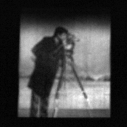

In [13]:
sample_image = Image.open(f"{DATA_PATH}/sample_image64/Cameraman64.png")
sample_image = sample_image.convert('L')
sample_image = np.asarray(sample_image).flatten() / 255

Hf = H @ sample_image
Hf_img = Hf.reshape(m, m)
Hf_pil = Image.fromarray(np.uint8(Hf_img * 255), mode='L')

DIRECTORY = DATA_PATH + '/240423'
if not os.path.exists(DIRECTORY):
    os.makedirs(DIRECTORY)
FILENAME = f"Cameraman64_{ratio}.png"

# plt.figure(figsize=(12, 8))
# sns.heatmap(Hf_img, annot=False, cmap='viridis')

fig, ax = plt.subplots(figsize=Hf_img.shape[::-1], dpi=1, tight_layout=True)
ax.imshow(Hf_img, cmap='gray')
ax.axis('off')
fig.savefig(f"{DIRECTORY}/{FILENAME}", dpi=1)
plt.show()

# fig, ax = plt.subplots(figsize=Hf_img.shape[::-1], dpi=1, tight_layout=True)
# ax.imshow(Hf_pil, cmap='gray')
# ax.axis('off')
# fig.savefig(f"{DIRECTORY}/{FILENAME}", dpi=1)
# plt.show()

In [14]:
rem = np.linalg.norm(H_true-H, 'fro')
print(rem)

12.942818783338815


In [15]:
def is_full_rank(matrix):
    rows, cols = matrix.shape
    rank = np.linalg.matrix_rank(matrix)
    
    if rank == min(rows, cols):
        return True
    else:
        return False

print(F_hat.T.shape)
print("F is full rank:", is_full_rank(F_hat.T))

(2048, 4096)
F is full rank: True
